<a href="https://colab.research.google.com/github/alamwasim/Jobathon-May21/blob/main/Jobathon_May21_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# !pip install pycaret

In [2]:
pip install catboost

     |████████████████████████████████| 67.3MB 57kB/s 


In [5]:

from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np
import pandas_profiling 
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
# from pycaret.classification import *
# import category_encoders as ce
from sklearn.model_selection import train_test_split

# Importing Data from locally uploaded csv file

In [6]:
train=pd.read_csv('/content/job-a-thon-train.csv')
test=pd.read_csv('/content/job-a-thon-test.csv')
train.shape,test.shape

((245725, 11), (105312, 10))

In [7]:
train.describe(include='all')

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
count,245725,245725,245725.000000,245725,245725,245725,245725.000000,216400,2.457250e+05,245725,245725.000000
unique,245725,2,NaN,35,4,4,NaN,2,NaN,2,NaN
top,CPTSFXK8,Male,NaN,RG268,Self_Employed,X1,NaN,No,NaN,No,NaN
freq,1,134197,NaN,35934,100886,103718,NaN,144357,NaN,150290,NaN
mean,NaN,NaN,43.856307,NaN,NaN,NaN,46.959141,NaN,1.128403e+06,NaN,0.237208
std,NaN,NaN,14.828672,NaN,NaN,NaN,32.353136,NaN,8.529364e+05,NaN,0.425372
min,NaN,NaN,23.000000,NaN,NaN,NaN,7.000000,NaN,2.079000e+04,NaN,0.000000
25%,NaN,NaN,30.000000,NaN,NaN,NaN,20.000000,NaN,6.043100e+05,NaN,0.000000
50%,NaN,NaN,43.000000,NaN,NaN,NaN,32.000000,NaN,8.946010e+05,NaN,0.000000
75%,NaN,NaN,54.000000,NaN,NaN,NaN,73.000000,NaN,1.366666e+06,NaN,0.000000


In [8]:
test.describe(include='all')

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
count,105312,105312,105312.000000,105312,105312,105312,105312.000000,92790,1.053120e+05,105312
unique,105312,2,NaN,35,4,4,NaN,2,NaN,2
top,MBJHJUHN,Male,NaN,RG268,Self_Employed,X1,NaN,No,NaN,No
freq,1,57705,NaN,15125,43192,44484,NaN,61608,NaN,63797
mean,NaN,NaN,43.871002,NaN,NaN,NaN,46.842819,NaN,1.134195e+06,NaN
std,NaN,NaN,14.872890,NaN,NaN,NaN,32.273634,NaN,8.662430e+05,NaN
min,NaN,NaN,24.000000,NaN,NaN,NaN,7.000000,NaN,2.259700e+04,NaN
25%,NaN,NaN,30.000000,NaN,NaN,NaN,20.000000,NaN,6.039822e+05,NaN
50%,NaN,NaN,43.000000,NaN,NaN,NaN,32.000000,NaN,8.966345e+05,NaN
75%,NaN,NaN,54.000000,NaN,NaN,NaN,73.000000,NaN,1.371598e+06,NaN


In [9]:
train.Credit_Product.value_counts(dropna=False,normalize=True)

No     0.587474
Yes    0.293185
NaN    0.119341
Name: Credit_Product, dtype: float64

In [10]:
test.Credit_Product.value_counts(dropna=False,normalize=True)

No     0.585005
Yes    0.296092
NaN    0.118904
Name: Credit_Product, dtype: float64

# Appending test and train data together

In [61]:
df=train.append(test,ignore_index=True)

# Imputing Credit Product

In [84]:
from catboost import CatBoostClassifier,Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,f1_score,mean_squared_error

X,y=train[~train.Credit_Product.isna()].drop(['ID','Is_Lead','Credit_Product'],axis=1),train[~train.Credit_Product.isna()]['Credit_Product']

for col in X.select_dtypes('object').columns:
  X[col]=X[col].astype('category')
print(X.dtypes)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state = 123,stratify=y)

categorical_features_indices = np.where(X_train.dtypes =='category')[0]
categorical_features_indices

cat_model=CatBoostClassifier(n_estimators=3000,random_state=123,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=20)
cat_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], early_stopping_rounds=100,verbose=200,cat_features=categorical_features_indices)
pred=cat_model.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val,pred))

Gender                 category
Age                       int64
Region_Code            category
Occupation             category
Channel_Code           category
Vintage                   int64
Avg_Account_Balance       int64
Is_Active              category
dtype: object
0:	test: 0.5354357	test1: 0.5368236	best: 0.5368236 (0)	total: 135ms	remaining: 6m 45s
200:	test: 0.7427308	test1: 0.7384201	best: 0.7384201 (200)	total: 29.3s	remaining: 6m 48s
400:	test: 0.7619808	test1: 0.7567038	best: 0.7567038 (400)	total: 59.3s	remaining: 6m 24s
600:	test: 0.7687582	test1: 0.7605874	best: 0.7605874 (600)	total: 1m 30s	remaining: 6m
800:	test: 0.7721841	test1: 0.7612976	best: 0.7613081 (795)	total: 2m 1s	remaining: 5m 34s
1000:	test: 0.7747194	test1: 0.7615718	best: 0.7615718 (1000)	total: 2m 32s	remaining: 5m 4s
1200:	test: 0.7768719	test1: 0.7617133	best: 0.7617133 (1200)	total: 3m 3s	remaining: 4m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7617244873
bestIteration = 

In [85]:
%%time
auc=[]
y_pred_tot=[]
model=[]

X,y=train[~train.Credit_Product.isna()].drop(['ID','Is_Lead','Credit_Product'],axis=1),train[~train.Credit_Product.isna()]['Credit_Product']
Xtest=df[df.Credit_Product.isna()][X.columns]
for col in X.select_dtypes('object').columns:
  X[col]=X[col].astype('category')
print(X.dtypes)
categorical_features_indices = np.where(X_train.dtypes =='category')[0]
categorical_features_indices

from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold,GroupShuffleSplit
fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1994)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    m=CatBoostClassifier(n_estimators=3000,random_state=1994,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=20)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=200,cat_features=categorical_features_indices)
    model.append(m)
    
    preds=m.predict_proba(X_test,ntree_end=m.best_iteration_)[:,-1]
    print("err: ",roc_auc_score(y_test,preds))
    auc.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(Xtest,ntree_end=m.best_iteration_)[:,-1]
    y_pred_tot.append(p)

Gender                 category
Age                       int64
Region_Code            category
Occupation             category
Channel_Code           category
Vintage                   int64
Avg_Account_Balance       int64
Is_Active              category
dtype: object
0:	test: 0.7056377	test1: 0.7086481	best: 0.7086481 (0)	total: 219ms	remaining: 10m 55s
200:	test: 0.7404058	test1: 0.7434070	best: 0.7434070 (200)	total: 31.9s	remaining: 7m 23s
400:	test: 0.7608209	test1: 0.7618558	best: 0.7618558 (400)	total: 1m 5s	remaining: 7m 4s
600:	test: 0.7669592	test1: 0.7654527	best: 0.7654618 (599)	total: 1m 41s	remaining: 6m 44s
800:	test: 0.7700907	test1: 0.7664458	best: 0.7664621 (793)	total: 2m 16s	remaining: 6m 16s
1000:	test: 0.7725295	test1: 0.7668951	best: 0.7668964 (998)	total: 2m 52s	remaining: 5m 45s
1200:	test: 0.7744959	test1: 0.7669696	best: 0.7669753 (1158)	total: 3m 29s	remaining: 5m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7669783691
bestIterat

In [131]:
pred=[]
for x in np.mean(y_pred_tot,0):
  if x>=0.5:pred.append('Yes')
  else: pred.append('No')

In [132]:
df['Credit_Product_Imputed']=df['Credit_Product']
df.loc[df.Credit_Product.isna(),'Credit_Product_Imputed']=pred

In [136]:
df.loc[df.Credit_Product.isna()].head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Credit_Product_Imputed,Credit_Product_Missing,F1,F2,F3,F4,F5,F6,Is_Active_bool,Credit_Product_bool,A_Avg_Account_Balance_sum,A_Avg_Account_Balance_max,A_Avg_Account_Balance_min,A_Avg_Account_Balance_mean,A_Vintage_max,A_Vintage_min,A_Vintage_mean,A_Age_max,A_Age_min,A_Channel_Code_nunique,A_Region_Code_nunique,A_Credit_Product_bool_mean,B_Avg_Account_Balance_sum,B_Avg_Account_Balance_max,B_Avg_Account_Balance_min,B_Avg_Account_Balance_mean,B_Vintage_sum,B_Vintage_max,B_Vintage_min,B_Vintage_mean,B_Age_mean,B_Age_min,B_Region_Code_nunique,B_Credit_Product_bool_sum,B_Credit_Product_bool_mean,B_Is_Active_bool_mean,C_Avg_Account_Balance_sum,C_Avg_Account_Balance_min,C_Vintage_min,C_Age_min,C_Channel_Code_nunique,C_Region_Code_nunique,D_Avg_Account_Balance_sum,D_Avg_Account_Balance_max,D_Avg_Account_Balance_min,D_Vintage_sum,D_Vintage_max,D_Vintage_min,D_Age_min,E_Avg_Account_Balance_sum,E_Avg_Account_Balance_max,E_Avg_Account_Balance_min,E_Vintage_sum,E_Vintage_max,E_Vintage_min,E_Age_max,E_Age_min,E_Occupation_nunique,E_Region_Code_nunique,E_Credit_Product_bool_sum
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1.0,No,Yes,RG282|Other,RG282|X3,Other|X3,Male|Other,Male|X3,nan|Yes,1,0,121471695070,10352009,20790,1.211035e+06,135,7,54.805780,85,24,4,35,0.306698,49190672720,10352009,66812,1.347985e+06,2902044,135,7,79.525485,63.927683,24,35,13291,0.364217,0.509262,70047034965,20790,7,24,4,35,30611092833,10352009,66812,1865927,135,7,24,75549691401,10352009,44856,4602451,135,7,85,24,4,35,22435
15,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1.0,No,Yes,RG268|Self_Employed,RG268|X2,Self_Employed|X2,Male|Self_Employed,Male|X2,nan|Yes,1,0,163248249301,8762071,22597,1.133055e+06,135,7,55.559676,61,23,4,35,0.333937,68893052950,8762071,47526,1.103596e+06,3326700,117,7,53.290296,47.175776,23,35,20587,0.329782,0.533512,96856093011,22597,7,24,4,35,43930161329,8762071,57672,2187199,117,7,24,70545676252,9878021,20790,3473378,117,7,85,24,4,35,21685
31,ABPMK4WU,Female,32,RG279,Salaried,X4,15,NaN,1072850,Yes,1.0,No,Yes,RG279|Salaried,RG279|X4,Salaried|X4,Female|Salaried,Female|X4,nan|Yes,1,0,106663873782,9701151,45950,1.036457e+06,134,7,26.311217,65,24,4,35,0.214241,910221932,7422057,118548,1.059630e+06,10690,15,7,12.444703,34.087311,24,34,461,0.536671,0.378347,56543232971,48389,7,24,4,35,389163851,7422057,129228,4330,15,7,24,3047804460,7939847,118743,38028,15,7,85,24,4,35,1446
36,MTEIXMB9,Female,41,RG268,Self_Employed,X3,62,NaN,962383,No,1.0,No,Yes,RG268|Self_Employed,RG268|X3,Self_Employed|X3,Female|Self_Employed,Female|X3,nan|No,0,0,163248249301,8762071,22597,1.133055e+06,135,7,55.559676,61,23,4,35,0.333937,64625208152,8680305,44856,1.223406e+06,3881268,135,7,73.475466,50.086514,24,35,19533,0.369775,0.530498,66392156290,47526,7,23,4,35,26415728325,8643247,66812,1493682,135,7,24,49650123374,9908858,66812,2730300,135,7,85,24,4,35,14323
40,6WX9JDVK,Female,63,RG254,Other,X3,103,NaN,1249319,Yes,1.0,No,Yes,RG254|Other,RG254|X3,Other|X3,Female|Other,Female|X3,nan|Yes,1,0,121471695070,10352009,20790,1.211035e+06,135,7,54.805780,85,24,4,35,0.306698,49190672720,10352009,66812,1.347985e+06,2902044,135,7,79.525485,63.927683,24,35,13291,0.364217,0.509262,51424660105,45657,7,24,4,35,18579579887,9908858,80456,1036117,135,7,24,49650123374,9908858,66812,2730300,135,7,85,24,4,35,14323


In [112]:
df.to_csv('df_imputed.csv',index=False)

# Feature Engineering 

In [62]:
df['Credit_Product_Missing']=df['Credit_Product'].apply(lambda x : 'Yes' if pd.isna(x) else 'No')

## Combine different categorical columns together

In [63]:
df['F1'] = (df['Region_Code'].astype(str)+'|'+df['Occupation'].astype(str))
df['F2'] = (df['Region_Code'].astype(str)+'|'+df['Channel_Code'].astype(str))
df['F3'] = (df['Occupation'].astype(str)+'|'+df['Channel_Code'].astype(str))
df['F4'] = (df['Gender'].astype(str)+'|'+df['Occupation'].astype(str))
df['F5'] = (df['Gender'].astype(str)+'|'+df['Channel_Code'].astype(str))
df['F6'] = (df['Credit_Product'].astype(str)+'|'+df['Is_Active'].astype(str))
df['F7'] = (df['Occupation'].astype(str)+'|'+df['Channel_Code'].astype(str) + '|'+ df['Credit_Product'].astype(str))

In [64]:
df.tail()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Credit_Product_Missing,F1,F2,F3,F4,F5,F6,F7
351032,DBENJOYI,Male,52,RG268,Salaried,X2,86,Yes,4242558,Yes,NaN,No,RG268|Salaried,RG268|X2,Salaried|X2,Male|Salaried,Male|X2,Yes|Yes,Salaried|X2|Yes
351033,CWQ72DWS,Male,55,RG277,Other,X2,86,Yes,1159153,No,NaN,No,RG277|Other,RG277|X2,Other|X2,Male|Other,Male|X2,Yes|No,Other|X2|Yes
351034,HDESC8GU,Male,35,RG254,Salaried,X4,15,No,1703727,No,NaN,No,RG254|Salaried,RG254|X4,Salaried|X4,Male|Salaried,Male|X4,No|No,Salaried|X4|No
351035,2PW4SFCA,Male,53,RG254,Other,X3,93,No,737178,Yes,NaN,No,RG254|Other,RG254|X3,Other|X3,Male|Other,Male|X3,No|Yes,Other|X3|No
351036,F2NOYPPZ,Male,27,RG256,Salaried,X1,21,No,591565,No,NaN,No,RG256|Salaried,RG256|X1,Salaried|X1,Male|Salaried,Male|X1,No|No,Salaried|X1|No


## Aggregate columns to get new features

In [65]:
print(df['Is_Active'].value_counts(dropna=False),'\n')
df['Is_Active_bool']=df['Is_Active'].apply(lambda x : 1 if x=='Yes' else 0)

print(df['Credit_Product'].value_counts(dropna=False))
df['Credit_Product_bool']=df['Credit_Product'].apply(lambda x : 1 if x=='Yes' else 0)

No     214087
Yes    136950
Name: Is_Active, dtype: int64 

No     205965
Yes    103225
NaN     41847
Name: Credit_Product, dtype: int64


In [66]:
agg_data={
    'Avg_Account_Balance':['sum','max','min','mean'],
    'Vintage':['sum','max','min','mean'],
    'Age':['mean','max','min'],
    'Channel_Code':['size','nunique'],
    'Region_Code':['size','nunique'],
    'Credit_Product_bool':['sum','mean'],
    'Is_Active_bool' : ['sum','mean'] 
}

df1 = df.groupby(['Occupation']).agg(agg_data)

df1.columns=['A_' + '_'.join(col).strip() for col in df1.columns.values]
df1.reset_index(inplace=True)
df1.head()
df=df.merge(df1,on='Occupation',how='left')

In [67]:
agg_data={
    'Avg_Account_Balance':['sum','max','min','mean'],
    'Vintage':['sum','max','min','mean'],
    'Age':['mean','max','min'],
    'Region_Code':['size','nunique'],
    'Credit_Product_bool':['sum','mean'],
    'Is_Active_bool' : ['sum','mean'] 
}

df1 = df.groupby(['Channel_Code','Occupation']).agg(agg_data)

df1.columns=['B_' + '_'.join(col).strip() for col in df1.columns.values]
df1.reset_index(inplace=True)
df1.head()
df=df.merge(df1,on=['Channel_Code','Occupation'],how='left')

In [68]:
# agg_data={
#     'Avg_Account_Balance':['sum','max','min','mean'],
#     'Vintage':['sum','max','min','mean'],
#     'Age':['mean','max','min'],
#     'Channel_Code':['size','nunique'],
#     'Region_Code':['size','nunique'],
#     'Credit_Product_bool':['sum','mean'],
#     'Is_Active_bool' : ['sum','mean'] 
# }

# df1 = df.groupby(['Gender','Occupation']).agg(agg_data)

# df1.columns=['C_' + '_'.join(col).strip() for col in df1.columns.values]
# df1.reset_index(inplace=True)
# df1.head()
# df=df.merge(df1,on=['Gender','Occupation'],how='left')

In [69]:
# agg_data={
#     'Avg_Account_Balance':['sum','max','min','mean'],
#     'Vintage':['sum','max','min','mean'],
#     'Age':['mean','max','min'],
#     'Region_Code':['size','nunique'],
#     'Credit_Product_bool':['sum','mean'],
#     'Is_Active_bool' : ['sum','mean'] 
# }

# df1 = df.groupby(['Gender','Occupation','Channel_Code']).agg(agg_data)

# df1.columns=['D_' + '_'.join(col).strip() for col in df1.columns.values]
# df1.reset_index(inplace=True)
# df1.head()
# df=df.merge(df1,on=['Gender','Occupation','Channel_Code'],how='left')

In [70]:
# agg_data={
#     'Avg_Account_Balance':['sum','max','min','mean'],
#     'Vintage':['sum','max','min','mean'],
#     'Age':['mean','max','min'],
#     'Occupation':['size','nunique'],
#     'Region_Code':['size','nunique'],
#     'Credit_Product_bool':['sum','mean'],
#     'Is_Active_bool' : ['sum','mean'] 
# }

# df1 = df.groupby(['Gender','Channel_Code']).agg(agg_data)

# df1.columns=['E_' + '_'.join(col).strip() for col in df1.columns.values]
# df1.reset_index(inplace=True)
# df1.head()
# df=df.merge(df1,on=['Gender','Channel_Code'],how='left')

In [71]:
# agg_data={
#     'Avg_Account_Balance':['sum','max','min','mean'],
#     'Vintage':['sum','max','min','mean'],
#     'Age':['mean','max','min'],
#     'Channel_Code':['size','nunique'],
#     # 'Region_Code':['size','nunique'],
#     'Occupation':['size','nunique'],
#     'Credit_Product_bool':['sum','mean'],
#     'Is_Active_bool' : ['sum','mean'] 
# }


# df1 = df.groupby(['Region_Code']).agg(agg_data)

# df1.columns=['F_' + '_'.join(col).strip() for col in df1.columns.values]
# df1.reset_index(inplace=True)
# df1.head()
# df=df.merge(df1,on=['Region_Code'],how='left')

In [72]:
agg_data={
    'Avg_Account_Balance':['sum','max','min','mean'],
    'Vintage':['sum','max','min','mean'],
    'Age':['mean','max','min'],
    # 'Channel_Code':['size','nunique'],
    # 'Region_Code':['size','nunique'],
    # 'Occupation':['size','nunique'],
    'Credit_Product_bool':['sum','mean'],
    'Is_Active_bool' : ['sum','mean'] 
}

groupby_col=['Region_Code','Occupation','Channel_Code']
df1 = df.groupby(groupby_col).agg(agg_data)

df1.columns=['G_' + '_'.join(col).strip() for col in df1.columns.values]
df1.reset_index(inplace=True)
df1.head()
df=df.merge(df1,on=groupby_col,how='left')

In [73]:
agg_data={
    'Avg_Account_Balance':['sum','max','min','mean'],
    'Vintage':['sum','max','min','mean'],
    'Age':['mean','max','min'],
    'Channel_Code':['size','nunique'],
    'Region_Code':['size','nunique'],
    'Occupation':['size','nunique'],
    # 'Credit_Product_bool':['sum','mean'],
    # 'Is_Active_bool' : ['sum','mean'] 
}

groupby_col=['Credit_Product_bool','Is_Active_bool']
df1 = df.groupby(groupby_col).agg(agg_data)

df1.columns=['H_' + '_'.join(col).strip() for col in df1.columns.values]
df1.reset_index(inplace=True)
df1.head()
df=df.merge(df1,on=groupby_col,how='left')

In [74]:
agg_data={
    'Avg_Account_Balance':['sum','max','min','mean'],
    'Vintage':['sum','max','min','mean'],
    'Age':['mean','max','min'],
    # 'Channel_Code':['size','nunique'],
    'Region_Code':['size','nunique'],
    'Occupation':['size','nunique'],
    # 'Credit_Product_bool':['sum','mean'],
    'Is_Active_bool' : ['sum','mean'] 
}

groupby_col=['Credit_Product_bool','Channel_Code']
df1 = df.groupby(groupby_col).agg(agg_data)

df1.columns=['I_' + '_'.join(col).strip() for col in df1.columns.values]
df1.reset_index(inplace=True)
df1.head()
df=df.merge(df1,on=groupby_col,how='left')

In [75]:
print(df.shape)
df.head()

(351037, 106)


,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Credit_Product_Missing,F1,F2,F3,F4,F5,F6,F7,Is_Active_bool,Credit_Product_bool,A_Avg_Account_Balance_sum,A_Avg_Account_Balance_max,A_Avg_Account_Balance_min,A_Avg_Account_Balance_mean,A_Vintage_sum,A_Vintage_max,A_Vintage_min,A_Vintage_mean,A_Age_mean,A_Age_max,A_Age_min,A_Channel_Code_size,A_Channel_Code_nunique,A_Region_Code_size,A_Region_Code_nunique,A_Credit_Product_bool_sum,A_Credit_Product_bool_mean,A_Is_Active_bool_sum,A_Is_Active_bool_mean,...,G_Age_max,G_Age_min,G_Credit_Product_bool_sum,G_Credit_Product_bool_mean,G_Is_Active_bool_sum,G_Is_Active_bool_mean,H_Avg_Account_Balance_sum,H_Avg_Account_Balance_max,H_Avg_Account_Balance_min,H_Avg_Account_Balance_mean,H_Vintage_sum,H_Vintage_max,H_Vintage_min,H_Vintage_mean,H_Age_mean,H_Age_max,H_Age_min,H_Channel_Code_size,H_Channel_Code_nunique,H_Region_Code_size,H_Region_Code_nunique,H_Occupation_size,H_Occupation_nunique,I_Avg_Account_Balance_sum,I_Avg_Account_Balance_max,I_Avg_Account_Balance_min,I_Avg_Account_Balance_mean,I_Vintage_sum,I_Vintage_max,I_Vintage_min,I_Vintage_mean,I_Age_mean,I_Age_max,I_Age_min,I_Region_Code_size,I_Region_Code_nunique,I_Occupation_size,I_Occupation_nunique,I_Is_Active_bool_sum,I_Is_Active_bool_mean
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0.0,No,RG268|Other,RG268|X3,Other|X3,Female|Other,Female|X3,No|No,Other|X3|No,0,0,121471695070,10352009,20790,1.211035e+06,5497239,135,7,54.805780,53.152157,85,24,100304,4,100304,35,30763,0.306698,41329,0.412037,...,85,25,2995,0.393665,3834,0.503943,148649696859,9908858,22597,1.044218e+06,5612013,135,7,39.422662,39.297987,85,24,142355,4,142355,35,142355,4,76616693028,9908858,44856,1.251436e+06,4594590,135,7,75.046796,54.973033,85,24,61223,35,61223,4,34962,0.571060
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0.0,No,RG277|Salaried,RG277|X1,Salaried|X1,Female|Salaried,Female|X1,No|No,Salaried|X1|No,0,0,106663873782,9701151,45950,1.036457e+06,2707740,134,7,26.311217,30.868801,65,24,102912,4,102912,35,22048,0.214241,23904,0.232276,...,63,24,829,0.144501,691,0.120446,148649696859,9908858,22597,1.044218e+06,5612013,135,7,39.422662,39.297987,85,24,142355,4,142355,35,142355,4,121784903896,9701151,22597,1.023833e+06,2972527,99,7,24.989718,31.849315,85,24,118950,35,118950,4,29028,0.244035
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0.0,No,RG268|Self_Employed,RG268|X3,Self_Employed|X3,Female|Self_Employed,Female|X3,No|Yes,Self_Employed|X3|No,1,0,163248249301,8762071,22597,1.133055e+06,8004927,135,7,55.559676,46.568116,61,23,144078,4,144078,35,48113,0.333937,70063,0.486285,...,61,24,4397,0.389840,5929,0.525667,125433197492,9701151,20790,1.189425e+06,5524823,135,7,52.389344,47.117403,85,24,105457,4,105457,35,105457,4,76616693028,9908858,44856,1.251436e+06,4594590,135,7,75.046796,54.973033,85,24,61223,35,61223,4,34962,0.571060
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0.0,No,RG270|Salaried,RG270|X1,Salaried|X1,Male|Salaried,Male|X1,No|No,Salaried|X1|No,0,0,106663873782,9701151,45950,1.036457e+06,2707740,134,7,26.311217,30.868801,65,24,102912,4,102912,35,22048,0.214241,23904,0.232276,...,62,24,672,0.137059,664,0.135427,148649696859,9908858,22597,1.044218e+06,5612013,135,7,39.422662,39.297987,85,24,142355,4,142355,35,142355,4,121784903896,9701151,22597,1.023833e+06,2972527,99,7,24.989718,31.849315,85,24,118950,35,118950,4,29028,0.244035
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0.0,No,RG282|Salaried,RG282|X1,Salaried|X1,Female|Salaried,Female|X1,No|No,Salaried|X1|No,0,0,106663873782,9701151,45950,1.036457e+06,2707740,134,7,26.311217,30.868801,65,24,102912,4,102912,35,22048,0.214241,23904,0.232276,...,63,24,461,0.158856,339,0.116816,148649696859,9908858,22597,1.044218e+06,5612013,135,7,39.422662,39.297987,85,24,142355,4,142355,35,142355,4,121784903896,9701151,22597,1.023833e+06,2972527,99,7,24.989718,31.849315,85,24,118950,35,118950,4,29028,0.244035


## Removing high correlated columns

In [76]:
%%time
to_drop=[]
corr_matrix = df.drop(['ID','Is_Lead'],axis=1).corr()
# print(corr_matrix)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# print(upper)

to_drop = [column for column in upper.columns if any(upper[column] > 0.93)]
print(to_drop)
print(f"No. of Columns to be Dropped:{len(to_drop)}")

['A_Vintage_sum', 'A_Age_mean', 'A_Channel_Code_size', 'A_Region_Code_size', 'A_Credit_Product_bool_sum', 'A_Is_Active_bool_sum', 'A_Is_Active_bool_mean', 'B_Age_max', 'B_Region_Code_size', 'B_Is_Active_bool_sum', 'G_Vintage_mean', 'G_Age_mean', 'G_Credit_Product_bool_sum', 'G_Is_Active_bool_sum', 'H_Avg_Account_Balance_min', 'H_Vintage_sum', 'H_Vintage_mean', 'H_Age_mean', 'H_Channel_Code_size', 'H_Region_Code_size', 'H_Occupation_size', 'I_Avg_Account_Balance_mean', 'I_Vintage_mean', 'I_Age_mean', 'I_Region_Code_size', 'I_Occupation_size']
No. of Columns to be Dropped:26
CPU times: user 6.13 s, sys: 215 ms, total: 6.35 s
Wall time: 6.33 s


In [77]:
print(f"Columns Dropped:{len(to_drop)}")
df.drop(to_drop,inplace=True,axis=1)
df.shape

Columns Dropped:26


(351037, 80)

## Catboost on only Imputed columns

In [137]:
df_train=df[~df.Is_Lead.isna()]
df_test=df[df.Is_Lead.isna()]

In [138]:
train_columns=['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product_Imputed', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead']

In [141]:
from catboost import CatBoostClassifier,Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,f1_score,mean_squared_error

X,y=df_train[train_columns].drop(['ID','Is_Lead'],axis=1),df_train['Is_Lead']

for col in X.select_dtypes('object').columns:
  X[col]=X[col].astype('category')
print(X.dtypes)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state = 123,stratify=y)

categorical_features_indices = np.where(X_train.dtypes =='category')[0]
categorical_features_indices

cat_model=CatBoostClassifier(n_estimators=3000,random_state=123,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=20)
cat_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], early_stopping_rounds=100,verbose=200,cat_features=categorical_features_indices)
pred=cat_model.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val,pred))


Gender                    category
Age                          int64
Region_Code               category
Occupation                category
Channel_Code              category
Vintage                      int64
Credit_Product_Imputed    category
Avg_Account_Balance          int64
Is_Active                 category
dtype: object
0:	test: 0.6966057	test1: 0.6929687	best: 0.6929687 (0)	total: 232ms	remaining: 11m 34s
200:	test: 0.7869457	test1: 0.7856014	best: 0.7856014 (200)	total: 33.1s	remaining: 7m 40s
400:	test: 0.8005530	test1: 0.7989856	best: 0.7989856 (400)	total: 1m 7s	remaining: 7m 14s
600:	test: 0.8054180	test1: 0.8010325	best: 0.8010325 (600)	total: 1m 43s	remaining: 6m 52s
800:	test: 0.8081284	test1: 0.8013799	best: 0.8013895 (793)	total: 2m 19s	remaining: 6m 21s
1000:	test: 0.8102305	test1: 0.8013533	best: 0.8014135 (904)	total: 2m 54s	remaining: 5m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8014134863
bestIteration = 904

Shrink model to first 9

In [143]:
x_test=df_test[train_columns].drop(['ID','Is_Lead'],axis=1)

for col in x_test.select_dtypes('object').columns:
  X[col]=X[col].astype('category')
Xpred_catboost=cat_model.predict_proba(x_test)[:,-1]
test['Is_Lead']=Xpred_catboost

In [144]:
submission=test[['ID','Is_Lead']]
submission.to_csv('catboost-imputed-v1.csv',index=False)

# Getting Feature Importance

In [96]:
df_train=df[~df.Is_Lead.isna()]
df_test=df[df.Is_Lead.isna()]
df_train.shape,train.shape,':',df_test.shape,test.shape

((245725, 80), (245725, 11), ':', (105312, 80), (105312, 11))

## Catboost feature Importance

In [79]:
from catboost import CatBoostClassifier,Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,f1_score,mean_squared_error

X,y=df_train.drop(['ID','Is_Lead'],axis=1),df_train['Is_Lead']
X.loc[X.Credit_Product.isna(),'Credit_Product']='nan'

for col in X.select_dtypes('object').columns:
  X[col]=X[col].astype('category')
# print(X.dtypes)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state = 123,stratify=y)

categorical_features_indices = np.where(X_train.dtypes =='category')[0]
categorical_features_indices

cat_model=CatBoostClassifier(n_estimators=3000,random_state=123,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=20)
cat_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], early_stopping_rounds=100,verbose=200,cat_features=categorical_features_indices)
pred=cat_model.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val,pred))

# 0.8737583677980174
# 0.8735053202201757  - feat eng v3

0:	test: 0.8304422	test1: 0.8300213	best: 0.8300213 (0)	total: 396ms	remaining: 19m 46s
200:	test: 0.8650629	test1: 0.8625172	best: 0.8625233 (194)	total: 1m 3s	remaining: 14m 45s
400:	test: 0.8751405	test1: 0.8727898	best: 0.8727898 (400)	total: 2m 8s	remaining: 13m 51s
600:	test: 0.8781422	test1: 0.8734640	best: 0.8734883 (594)	total: 3m 13s	remaining: 12m 50s
800:	test: 0.8799929	test1: 0.8734666	best: 0.8735053 (727)	total: 4m 17s	remaining: 11m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8735053202
bestIteration = 727

Shrink model to first 728 iterations.
0.8735053202201757


In [157]:
# x_test=df_test.drop(['ID','Is_Lead'],axis=1)
# x_test.loc[x_test.Credit_Product.isna(),'Credit_Product']='nan'

# for col in x_test.select_dtypes('object').columns:
#   X[col]=X[col].astype('category')
# Xpred_catboost=cat_model.predict_proba(x_test)[:,-1]
# test['Is_Lead']=Xpred_catboost
# submission=test[['ID','Is_Lead']]
# submission.to_csv('featured-all-catboost-v1.csv',index=False)

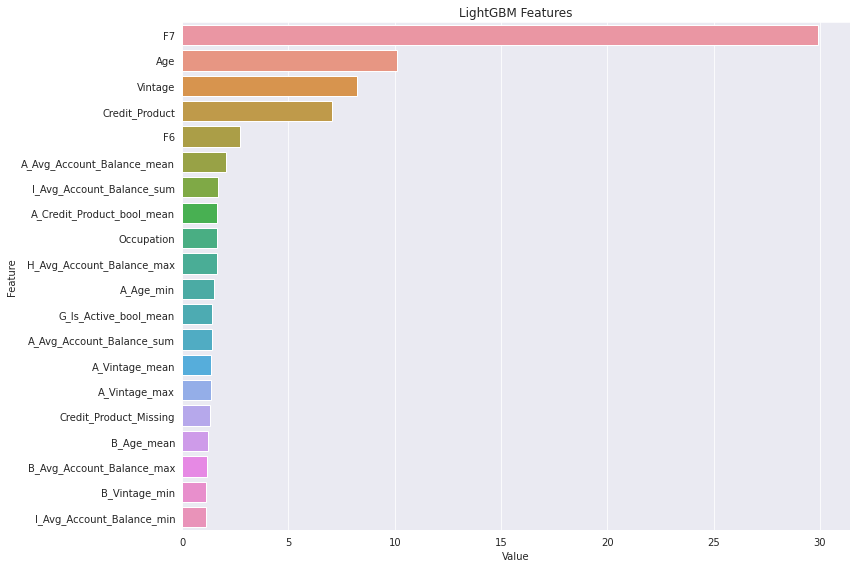

In [80]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

%matplotlib inline
feature_imp = pd.DataFrame(sorted(zip(cat_model.feature_importances_, X.columns), reverse=True)[:200], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [34]:
# pip install shap

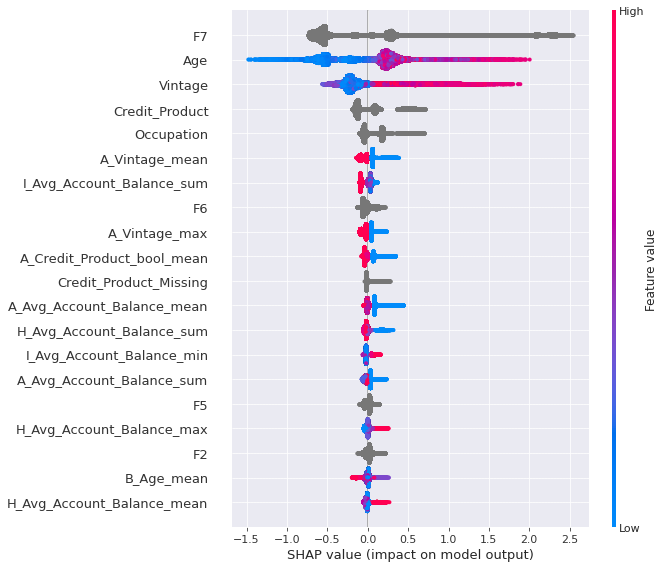

,column_name,shap_importance
16,F7,0.695256
1,Age,0.351699
5,Vintage,0.334066
6,Credit_Product,0.16809
3,Occupation,0.0899932
...,...,...
59,H_Vintage_max,0
74,I_Region_Code_nunique,0
75,I_Occupation_nunique,0
24,A_Vintage_min,0


In [81]:
import shap
shap.initjs()

shap_values = shap.TreeExplainer(cat_model).shap_values(X)

shap.summary_plot(shap_values, X)


shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [86]:
cat_feat_cols= importance_df[importance_df.shap_importance>0.01]['column_name'].values
len(cat_feat_cols)

40

In [53]:
from catboost import CatBoostClassifier,Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,f1_score,mean_squared_error

X,y=df_train.drop(['ID','Is_Lead'],axis=1),df_train['Is_Lead']
X.loc[X.Credit_Product.isna(),'Credit_Product']='nan'

for col in X.select_dtypes('object').columns:
  X[col]=X[col].astype('category')
# print(X.dtypes)
X_train,X_val,y_train,y_val = train_test_split(X[cat_feat_cols],y,test_size=0.25,random_state = 123,stratify=y)

categorical_features_indices = np.where(X_train.dtypes =='category')[0]
categorical_features_indices

cat_model=CatBoostClassifier(n_estimators=3000,random_state=123,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=20)
cat_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], early_stopping_rounds=100,verbose=200,cat_features=categorical_features_indices)
pred=cat_model.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val,pred))

#Base
# Shrink model to first 741 iterations.
# 0.8737583677980174

#with shap importance (first version)
# Shrink model to first 712 iterations.
# 0.873807840304121

0:	test: 0.7051260	test1: 0.7015268	best: 0.7015268 (0)	total: 440ms	remaining: 22m
200:	test: 0.8653016	test1: 0.8624157	best: 0.8624157 (200)	total: 1m 7s	remaining: 15m 46s
400:	test: 0.8753510	test1: 0.8724641	best: 0.8724641 (400)	total: 2m 18s	remaining: 14m 57s
600:	test: 0.8784629	test1: 0.8732288	best: 0.8732332 (598)	total: 3m 26s	remaining: 13m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8732730417
bestIteration = 620

Shrink model to first 621 iterations.
0.8732730416637523


In [87]:
ignore_col=['Credit_Product_Imputed','Credit_Product_bool','Is_Active_bool']
cat_feat_cols_2=[x for x in cat_feat_cols if x not in ignore_col]
from catboost import CatBoostClassifier,Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,f1_score,mean_squared_error

X,y=df_train.drop(['ID','Is_Lead'],axis=1),df_train['Is_Lead']
X.loc[X.Credit_Product.isna(),'Credit_Product']='nan'

for col in X.select_dtypes('object').columns:
  X[col]=X[col].astype('category')
# print(X.dtypes)
X_train,X_val,y_train,y_val = train_test_split(X[cat_feat_cols_2],y,test_size=0.25,random_state = 123,stratify=y)

categorical_features_indices = np.where(X_train.dtypes =='category')[0]
categorical_features_indices

cat_model=CatBoostClassifier(n_estimators=3000,random_state=123,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=20)
cat_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], early_stopping_rounds=100,verbose=200,cat_features=categorical_features_indices)
pred=cat_model.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val,pred))

#Base
# Shrink model to first 741 iterations.
# 0.8737583677980174

#with cat_feat_col
# Shrink model to first 712 iterations.
# 0.873807840304121

# ****************************************************************** #
#Dropping ignored cols along with cat_featcol
# Shrink model to first 765 iterations.
# # 0.8738620752455407
# ['Credit_Product', 'Age', 'Vintage', 'Credit_Product_Missing', 'F6',
#        'A_Vintage_mean', 'Occupation', 'A_Avg_Account_Balance_mean', 'F2',
#        'B_Age_mean', 'A_Credit_Product_bool_mean', 'A_Avg_Account_Balance_sum',
#        'Channel_Code', 'B_Vintage_max', 'A_Avg_Account_Balance_max',
#        'A_Avg_Account_Balance_min', 'B_Vintage_mean', 'Region_Code',
#        'E_Vintage_sum', 'F3', 'Avg_Account_Balance', 'B_Is_Active_bool_mean',
#        'D_Vintage_max', 'F1', 'D_Avg_Account_Balance_max', 'F5',
#        'D_Avg_Account_Balance_sum', 'F4', 'A_Age_max', 'A_Vintage_max',
#        'E_Avg_Account_Balance_min', 'B_Avg_Account_Balance_sum', 'Is_Active',
#        'D_Vintage_sum', 'E_Credit_Product_bool_sum',
#        'B_Avg_Account_Balance_min', 'B_Avg_Account_Balance_max',
#        'B_Avg_Account_Balance_mean', 'D_Avg_Account_Balance_min',
#        'C_Avg_Account_Balance_min', 'B_Vintage_sum',
#        'E_Avg_Account_Balance_sum', 'C_Avg_Account_Balance_sum',
#        'B_Credit_Product_bool_sum', 'E_Avg_Account_Balance_max',
#        'D_Vintage_min', 'B_Credit_Product_bool_mean', 'B_Age_min',
#        'E_Vintage_max', 'A_Age_min', 'E_Age_min', 'C_Age_min', 'D_Age_min',
#        'Gender', 'B_Vintage_min', 'B_Region_Code_nunique',
#        'C_Region_Code_nunique']

#V2 feature Eng. Taking only feat imp>0.01 along with dropping ignore col
# Shrink model to first 757 iterations.
# 0.8733851946723052

# 0.8734900099864695

0:	test: 0.7497583	test1: 0.7525504	best: 0.7525504 (0)	total: 333ms	remaining: 16m 39s
200:	test: 0.8650588	test1: 0.8624308	best: 0.8624308 (200)	total: 56.9s	remaining: 13m 11s
400:	test: 0.8755566	test1: 0.8729533	best: 0.8729533 (400)	total: 1m 58s	remaining: 12m 46s
600:	test: 0.8784597	test1: 0.8735895	best: 0.8736134 (555)	total: 3m	remaining: 12m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8736400509
bestIteration = 676

Shrink model to first 677 iterations.
0.8736400508625748


In [179]:
X_train.columns

Index(['Credit_Product', 'Age', 'Vintage', 'Credit_Product_Missing', 'F6',
       'A_Vintage_mean', 'Occupation', 'A_Avg_Account_Balance_mean', 'F2',
       'B_Age_mean', 'A_Credit_Product_bool_mean', 'A_Avg_Account_Balance_sum',
       'Channel_Code', 'B_Vintage_max', 'A_Avg_Account_Balance_max',
       'A_Avg_Account_Balance_min', 'B_Vintage_mean', 'Region_Code',
       'E_Vintage_sum', 'F3', 'Avg_Account_Balance', 'B_Is_Active_bool_mean',
       'D_Vintage_max', 'F1', 'D_Avg_Account_Balance_max', 'F5',
       'D_Avg_Account_Balance_sum', 'F4', 'A_Age_max', 'A_Vintage_max',
       'E_Avg_Account_Balance_min', 'B_Avg_Account_Balance_sum', 'Is_Active',
       'D_Vintage_sum', 'E_Credit_Product_bool_sum',
       'B_Avg_Account_Balance_min', 'B_Avg_Account_Balance_max',
       'B_Avg_Account_Balance_mean', 'D_Avg_Account_Balance_min',
       'C_Avg_Account_Balance_min', 'B_Vintage_sum',
       'E_Avg_Account_Balance_sum', 'C_Avg_Account_Balance_sum',
       'B_Credit_Product_bool_sum', '

In [59]:
importance_df[20:45]

,column_name,shap_importance
19,A_Avg_Account_Balance_sum,0.0251085
21,A_Avg_Account_Balance_min,0.0222728
34,B_Avg_Account_Balance_mean,0.0208266
20,A_Avg_Account_Balance_max,0.0205155
14,F5,0.0190222
104,I_Vintage_sum,0.0184443
44,B_Is_Active_bool_mean,0.0183319
105,I_Vintage_max,0.0146935
85,G_Vintage_max,0.0146337
4,Channel_Code,0.0140718


## LGBM Feature Importance

In [97]:
from lightgbm import LGBMClassifier

X,y=df_train.drop(['ID','Is_Lead'],axis=1),df_train['Is_Lead']
X.loc[X.Credit_Product.isna(),'Credit_Product']='nan'

for col in X.select_dtypes('object').columns:
  X[col]=X[col].astype('category')
print(X.dtypes)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state = 123,stratify=y)
lgbm_model=LGBMClassifier(n_estimators=5000,random_state=123,learning_rate=0.05,colsample_bytree=0.5,reg_alpha=4,min_split_gain=0.2,min_child_samples=2,bagging_fraction=0.9,max_depth=-1, )
lgbm_model.fit(X_train,y_train,eval_set=[(X_val, y_val)],eval_metric='AUC', early_stopping_rounds=200,verbose=200)
pred=lgbm_model.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val,pred))

#Base
# 0.8722364629094156

Gender                   category
Age                         int64
Region_Code              category
Occupation               category
Channel_Code             category
                           ...   
I_Age_min                   int64
I_Region_Code_nunique       int64
I_Occupation_nunique        int64
I_Is_Active_bool_sum        int64
I_Is_Active_bool_mean     float64
Length: 78, dtype: object
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.871767	valid_0's binary_logloss: 0.345616
Early stopping, best iteration is:
[124]	valid_0's auc: 0.872236	valid_0's binary_logloss: 0.345269
0.8722364629094156


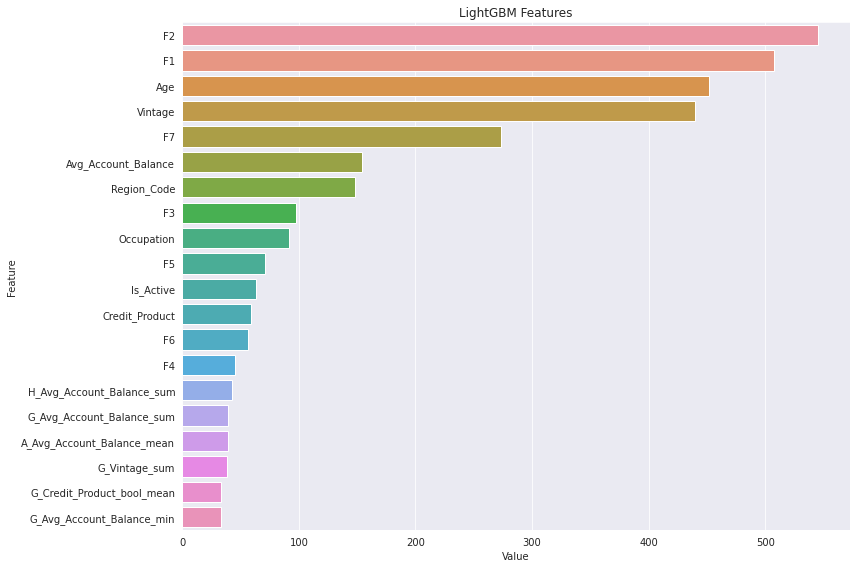

In [98]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

%matplotlib inline
feature_imp = pd.DataFrame(sorted(zip(lgbm_model.feature_importances_, X.columns), reverse=True)[:200], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

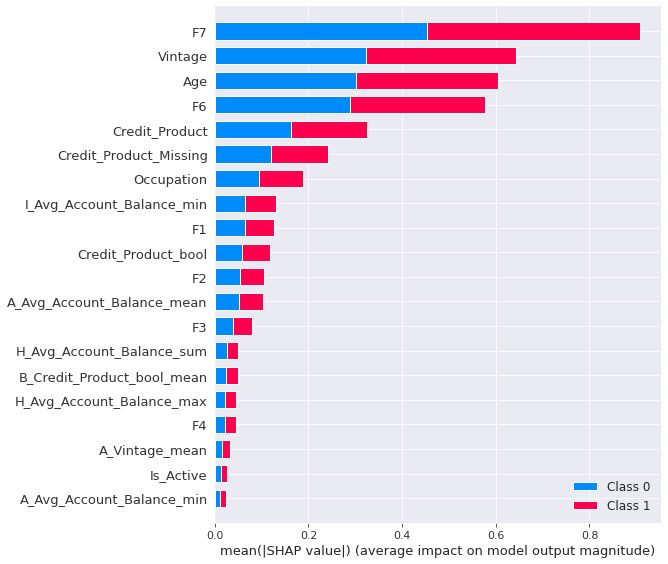

In [102]:
import shap
shap.initjs()

shap_values = shap.TreeExplainer(lgbm_model).shap_values(X)

shap.summary_plot(shap_values, X)

In [101]:
shap_sum = np.abs(shap_values).mean(axis=0).mean(axis=0)
lgbm_importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
lgbm_importance_df.columns = ['column_name', 'shap_importance']
lgbm_importance_df = lgbm_importance_df.sort_values('shap_importance', ascending=False)
lgbm_importance_df

,column_name,shap_importance
16,F7,0.453768
5,Vintage,0.322028
1,Age,0.302119
15,F6,0.288634
6,Credit_Product,0.162643
...,...,...
59,H_Vintage_max,0
65,H_Occupation_nunique,0
60,H_Vintage_min,0
63,H_Channel_Code_nunique,0


In [107]:
lgbm_feat_cols= lgbm_importance_df[lgbm_importance_df.shap_importance>0.01]['column_name'].values
len(lgbm_feat_cols)

24

In [108]:
ignore_col=['Credit_Product_Imputed','Credit_Product_bool','Is_Active_bool']
lgbm_feat_cols_2=[x for x in lgbm_feat_cols if x not in ignore_col]

from catboost import CatBoostClassifier,Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,f1_score,mean_squared_error

X,y=df_train.drop(['ID','Is_Lead'],axis=1),df_train['Is_Lead']
X.loc[X.Credit_Product.isna(),'Credit_Product']='nan'

for col in X.select_dtypes('object').columns:
  X[col]=X[col].astype('category')
# print(X.dtypes)
X_train,X_val,y_train,y_val = train_test_split(X[lgbm_feat_cols_2],y,test_size=0.25,random_state = 123,stratify=y)

lgbm_model=LGBMClassifier(n_estimators=5000,random_state=123,learning_rate=0.05,colsample_bytree=0.5,reg_alpha=4,min_split_gain=0.2,min_child_samples=2,bagging_fraction=0.9,max_depth=-1, )
lgbm_model.fit(X_train,y_train,eval_set=[(X_val, y_val)],eval_metric='AUC', early_stopping_rounds=200,verbose=200)
pred=lgbm_model.predict_proba(X_val)[:,-1]
print(roc_auc_score(y_val,pred))

#BAse
# 0.8722364629094156
# 0.87211316753029 -> feat_imp >0
# 0.8722265082187449 -> feat_imp>0.01

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.87197	valid_0's binary_logloss: 0.345683
Early stopping, best iteration is:
[148]	valid_0's auc: 0.872227	valid_0's binary_logloss: 0.345456
0.8722265082187449


# K fold Training 

In [123]:
df.loc[df.Credit_Product.isna(),'Credit_Product']='nan'
for col in df.select_dtypes('object').columns:
  df[col]=df[col].astype('category')
df_train=df[~df.Is_Lead.isna()]
df_test=df[df.Is_Lead.isna()]

## Catboost

In [89]:
%%time
catboost_auc=[]
catboost_y_pred_tot=[]
model=[]

X,y=df_train.drop(['ID','Is_Lead'],axis=1),df_train['Is_Lead']
Xtest=df_test.drop(['ID','Is_Lead'],axis=1)

cat_feat_cols= importance_df[importance_df.shap_importance>0.01]['column_name'].values
ignore_col=['Credit_Product_Imputed','Credit_Product_bool','Is_Active_bool']
cat_feat_cols_2=[x for x in cat_feat_cols if x not in ignore_col]
# print(X[cat_feat_cols_2].dtypes)
categorical_features_indices = np.where(X_train[cat_feat_cols_2].dtypes =='category')[0]
categorical_features_indices

from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold,GroupShuffleSplit
fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=123)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X[cat_feat_cols_2].iloc[train_index], X[cat_feat_cols_2].iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    m=CatBoostClassifier(n_estimators=3000,random_state=1994,eval_metric='AUC',learning_rate=0.05,random_strength=200,bagging_temperature=0.6,l2_leaf_reg=4,one_hot_max_size=20)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=200,cat_features=categorical_features_indices)
    # model.append(m)
    
    preds=m.predict_proba(X_test,ntree_end=m.best_iteration_)[:,-1]
    print("err: ",roc_auc_score(y_test,preds))
    catboost_auc.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(Xtest[cat_feat_cols_2],ntree_end=m.best_iteration_)[:,-1]
    catboost_y_pred_tot.append(p)

0:	test: 0.8350393	test1: 0.8323591	best: 0.8323591 (0)	total: 418ms	remaining: 20m 54s
200:	test: 0.8676417	test1: 0.8631778	best: 0.8631778 (200)	total: 1m 6s	remaining: 15m 27s
400:	test: 0.8754442	test1: 0.8701305	best: 0.8701305 (400)	total: 2m 15s	remaining: 14m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8706325797
bestIteration = 486

Shrink model to first 487 iterations.
err:  0.8706306667759119
0:	test: 0.8348435	test1: 0.8332704	best: 0.8332704 (0)	total: 381ms	remaining: 19m 1s
200:	test: 0.8660732	test1: 0.8645801	best: 0.8646091 (194)	total: 1m 6s	remaining: 15m 20s
400:	test: 0.8750798	test1: 0.8733333	best: 0.8733333 (400)	total: 2m 16s	remaining: 14m 43s
600:	test: 0.8778577	test1: 0.8743342	best: 0.8743403 (597)	total: 3m 28s	remaining: 13m 51s
800:	test: 0.8793548	test1: 0.8745126	best: 0.8745465 (760)	total: 4m 39s	remaining: 12m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8745465124
bestIteration = 760

Shri

In [90]:
X_train.columns

Index(['F7', 'Age', 'Vintage', 'Credit_Product', 'Occupation',
       'A_Vintage_mean', 'I_Avg_Account_Balance_sum', 'F6', 'A_Vintage_max',
       'A_Credit_Product_bool_mean', 'Credit_Product_Missing',
       'A_Avg_Account_Balance_mean', 'H_Avg_Account_Balance_sum',
       'I_Avg_Account_Balance_min', 'A_Avg_Account_Balance_sum', 'F5',
       'H_Avg_Account_Balance_max', 'F2', 'B_Age_mean',
       'H_Avg_Account_Balance_mean', 'Channel_Code', 'G_Is_Active_bool_mean',
       'G_Credit_Product_bool_mean', 'B_Is_Active_bool_mean',
       'A_Avg_Account_Balance_min', 'B_Avg_Account_Balance_max', 'Region_Code',
       'Avg_Account_Balance', 'I_Is_Active_bool_sum', 'B_Vintage_mean',
       'I_Vintage_sum', 'F1', 'A_Age_max', 'I_Vintage_max',
       'G_Avg_Account_Balance_min', 'G_Vintage_max', 'B_Vintage_sum',
       'G_Avg_Account_Balance_mean', 'I_Is_Active_bool_mean', 'F4'],
      dtype='object')

In [91]:
print(f"Mean AUC : {np.mean(catboost_auc)}")

Mean AUC : 0.8743061682061942


In [92]:
np.mean(catboost_y_pred_tot,0)

array([0.04461984, 0.86564794, 0.05837218, ..., 0.06988285, 0.21010253,
       0.0521723 ])

In [93]:
test['Is_Lead']=np.mean(catboost_y_pred_tot,0)
submission=test[['ID','Is_Lead']]
submission.to_csv('Kfold-catboost-featEngWtImp-v1.csv',index=False)

In [94]:
submission.head()

,ID,Is_Lead
0,VBENBARO,0.044620
1,CCMEWNKY,0.865648
2,VK3KGA9M,0.058372
3,TT8RPZVC,0.024455
4,SHQZEYTZ,0.021429


## LGBM

In [124]:
%%time
lgbm_auc=[]
lgbm_y_pred_tot=[]
model=[]

X,y=df_train.drop(['ID','Is_Lead'],axis=1),df_train['Is_Lead']
Xtest=df_test.drop(['ID','Is_Lead'],axis=1)

lgbm_feat_cols= lgbm_importance_df[lgbm_importance_df.shap_importance>0.01]['column_name'].values
ignore_col=['Credit_Product_Imputed','Credit_Product_bool','Is_Active_bool']
lgbm_feat_cols_2=[x for x in lgbm_feat_cols if x not in ignore_col]

from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold,GroupShuffleSplit
fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=123)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X[lgbm_feat_cols_2].iloc[train_index], X[lgbm_feat_cols_2].iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    m=LGBMClassifier(n_estimators=5000,random_state=123,learning_rate=0.05,colsample_bytree=0.5,reg_alpha=4,min_split_gain=0.2,min_child_samples=2,bagging_fraction=0.9,max_depth=-1, )
    m.fit(X_train,y_train,eval_set=[(X_test, y_test)],eval_metric='AUC', early_stopping_rounds=200,verbose=200)
    # model.append(m)
    
    preds=m.predict_proba(X_test,ntree_end=m.best_iteration_)[:,-1]
    print("err: ",roc_auc_score(y_test,preds))
    lgbm_auc.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(Xtest[lgbm_feat_cols_2],ntree_end=m.best_iteration_)[:,-1]
    lgbm_y_pred_tot.append(p)

Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.869821	valid_0's binary_logloss: 0.347903
Early stopping, best iteration is:
[185]	valid_0's auc: 0.869879	valid_0's binary_logloss: 0.347843
err:  0.8698789605697212
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.872903	valid_0's binary_logloss: 0.342566
Early stopping, best iteration is:
[148]	valid_0's auc: 0.872893	valid_0's binary_logloss: 0.342435
err:  0.8728928603410312
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.873144	valid_0's binary_logloss: 0.345508
Early stopping, best iteration is:
[148]	valid_0's auc: 0.873235	valid_0's binary_logloss: 0.345291
err:  0.8732346269374279
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's auc: 0.875306	valid_0's binary_logloss: 0.343885
Early stopping, best iteration is:
[124]	valid_0's auc: 0.875691	valid_0's binary_logloss: 0.343965
err:  0.87569

In [125]:
X_train.columns

Index(['F7', 'Vintage', 'Age', 'F6', 'Credit_Product',
       'Credit_Product_Missing', 'Occupation', 'I_Avg_Account_Balance_min',
       'F1', 'F2', 'A_Avg_Account_Balance_mean', 'F3',
       'H_Avg_Account_Balance_sum', 'B_Credit_Product_bool_mean',
       'H_Avg_Account_Balance_max', 'F4', 'A_Vintage_mean', 'Is_Active',
       'A_Avg_Account_Balance_min', 'A_Avg_Account_Balance_sum',
       'A_Vintage_max', 'Avg_Account_Balance', 'I_Avg_Account_Balance_sum'],
      dtype='object')

In [126]:
print(f"Mean AUC : {np.mean(lgbm_auc)}")

Mean AUC : 0.8734409117211609


In [127]:
np.mean(lgbm_y_pred_tot,0)

array([0.03525215, 0.87669369, 0.05392794, ..., 0.09888454, 0.2003108 ,
       0.05220347])

In [128]:
test['Is_Lead']=np.mean(lgbm_y_pred_tot,0)
submission=test[['ID','Is_Lead']]
submission.to_csv('Kfold-lgbm-featEngWtImp-v1.1.csv',index=False)

# Ensemble

In [129]:
m1=pd.read_csv('Kfold-catboost-featEngWtImp-v1.csv') #0.8743061682061942
m2=pd.read_csv('Kfold-lgbm-featEngWtImp-v1.1.csv') #0.8732367131547722

In [130]:
sub=m1.copy()
sub['Is_Lead']=m1.Is_Lead*0.85+m2.Is_Lead*0.15
sub.head()

,ID,Is_Lead
0,VBENBARO,0.043215
1,CCMEWNKY,0.867305
2,VK3KGA9M,0.057706
3,TT8RPZVC,0.024705
4,SHQZEYTZ,0.020953


In [131]:
sub.to_csv('ensemble-Kfold-Cat(85)Lgbm(15)-featEngWtImp-V1.1.csv',index=False)

In [122]:
0.8743061682061942*0.85+0.8732367131547722*0.15

0.8741457499484809